In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision 
import torchvision.transforms as transforms
from PIL import Image
import os
import time

from customDataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error


# from NeuralNetx8v1 import NeuralNet, Discriminator
from FourierLoss import BandFilterLoss, BandFilterLossTorch, FourierHeatMap, FourierLossTorch
from neuralNet1 import NeuralNet1
from neuralNet2 import NeuralNet2
from neuralNet3 import NeuralNet3
from VGG import VGGLoss

In [2]:
### Check if GPU is available

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Check for GPU availability and set device
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device = torch.device("cuda")
    current_device_idx = torch.cuda.current_device()
else:
    device_count = 0
    device = torch.device("cpu")
    current_device_idx = None

# Print device information
print(f"Number of available GPUs: {device_count}")
print(f"Current device index: {current_device_idx}")
if device == torch.device("cuda"):
    print(f"Current device name: {torch.cuda.get_device_name(current_device_idx)}")
else:
    print("Current device name: CPU")

Using GPU
Number of available GPUs: 1
Current device index: 0
Current device name: NVIDIA GeForce RTX 4080


In [3]:
# Dataset creation
batch_size = 16
train_X = "data/LR_train"
train_y = "data/HR_train"
val_X = "data/LR_val"
val_y = "data/HR_val"
test_X = "data/LR_test"
test_y = "data/HR_test"

# Define a transformation operation to normalize the images
transform = transforms.Compose([
    transforms.ToTensor()
])


train_dataset = CustomDataset(train_X, train_y, transform=transforms.ToTensor())
val_dataset = CustomDataset(val_X, val_y, transform=transforms.ToTensor())
test_dataset = CustomDataset(test_X, test_y, transform=transforms.ToTensor())

print("Batch Size:",batch_size)
print("Training Set Size: ", len(train_dataset))

#### Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Batch Size: 16
Training Set Size:  15000


In [4]:
#### Create the model
model = NeuralNet3()
# discriminator = Discriminator().to(device)

# Set up the adversarial loss (binary cross-entropy loss)
# adversarial_loss = torch.nn.BCEWithLogitsLoss()

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer_G = optim.Adam(model.parameters(), lr=0.002)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002)

# move them to device (GPU/CPU)
model.to(device)

# loss function
# VGG_loss = VGGLoss(device)
# r1 = 20
# r2 = 300
MSE_loss_fn = nn.MSELoss()
fourier_loss_fn = FourierLossTorch()
# Filter_loss_fn = BandFilterLoss(r1, r2)
# Filter_loss_fn2 = BandFilterLossTorch(r1, r2)

# weight_vgg = 0
# weight_filter = 0.5
# weight_adv = 0
weight_mse = 1
weight_fourier = 1

epochs = 100
print("Epochs:",epochs)

Epochs: 100


In [5]:
# Load the model
weights = os.listdir("Model_Weights")
weight = "Model_Weights/" + weights[3]
model = NeuralNet3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load(weight, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(weight)

Model_Weights/NN_3_(weighted-fourier-mse).pth


In [6]:
#### Training Loop with MSE and Fourier Loss
weight_mse = 1
weight_fourier = 0.01

# set model to train
model.train()
for epoch in range(epochs):
    print(f"------------------\n Epoch: {epoch}")
    
    if epoch == 10:
        weight_fourier = 0.1
    if epoch == 20:
        weight_fourier = 0.5
    if epoch == 30:
        weight_fourier = 1
    
    epoch_loss = 0
    batch_loss = 0
    mse_loss = 0
    fourier_loss = 0
    
    for i, (X, y) in enumerate(train_dataloader):
        
        start_time = time.time()
        
        # retrieve data and move tensors to device
        inputs = X.to(device)
        labels = y.to(device)
        
        # print('Modeling...')
        outputs = model(inputs)
        # print('Calculating Loss...')
        ##################
        # calculate loss # ---------------------------------------------------------------------
        ##################
        mse_loss = MSE_loss_fn(outputs, labels)
        fourier_loss = fourier_loss_fn(outputs, labels)
        loss = weight_fourier*fourier_loss # + weight_mse*mse_loss
        epoch_loss += loss.item()
        batch_loss += loss.item()
        ######################
        # end calculate loss # ---------------------------------------------------------------------
        ######################
        # print("Backpropagating...")
        # zero gradient and backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        time_remaining = elapsed_time * (len(train_dataloader) - i)
        if i % 10 == 0:
            print(f"\tBatch: {i}/{len(train_dataloader)} | Loss: {batch_loss/10:.8f} | MSE Loss: {mse_loss.item():.8f} | Fourier Loss: {fourier_loss.item():.8f} | Time Remaining: {time_remaining/60:.2f} minutes")
            batch_loss = 0
            
        
    # Print epoch information 
    print(f"Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}")

------------------
 Epoch: 0
	Batch: 0/938 | Loss: 2.27627506 | Fourier Loss: 227.62750244 | Time Remaining: 35.76 minutes
	Batch: 10/938 | Loss: 28.22855015 | Fourier Loss: 399.33123779 | Time Remaining: 10.65 minutes
	Batch: 20/938 | Loss: 29.57622757 | Fourier Loss: 330.96569824 | Time Remaining: 10.00 minutes
	Batch: 30/938 | Loss: 29.98245220 | Fourier Loss: 329.59497070 | Time Remaining: 10.65 minutes
	Batch: 40/938 | Loss: 30.69730186 | Fourier Loss: 297.38763428 | Time Remaining: 9.94 minutes
	Batch: 50/938 | Loss: 29.52622395 | Fourier Loss: 374.93423462 | Time Remaining: 9.45 minutes
	Batch: 60/938 | Loss: 29.69168091 | Fourier Loss: 359.06088257 | Time Remaining: 9.78 minutes
	Batch: 70/938 | Loss: 28.85341339 | Fourier Loss: 287.63977051 | Time Remaining: 9.59 minutes
	Batch: 80/938 | Loss: 27.13660374 | Fourier Loss: 271.77359009 | Time Remaining: 8.93 minutes
	Batch: 90/938 | Loss: 26.40225945 | Fourier Loss: 173.47924805 | Time Remaining: 9.39 minutes
	Batch: 100/938 | L

KeyboardInterrupt: 

In [8]:
# Save the model
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'Model_Weights/NN_3_(weighted-fourier-mse).pth')


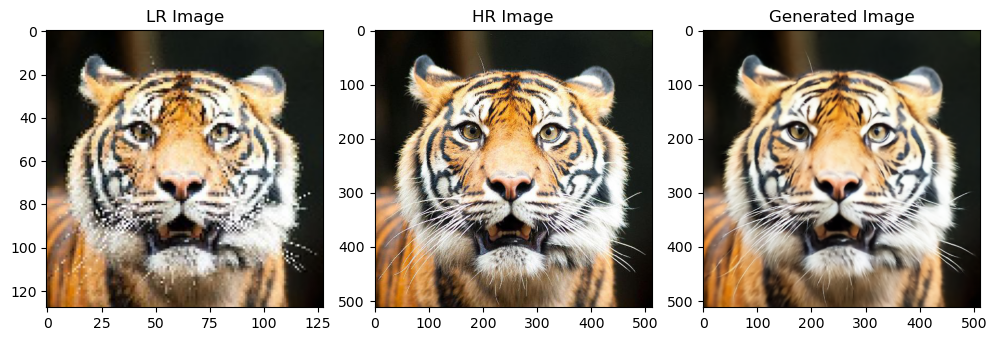

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


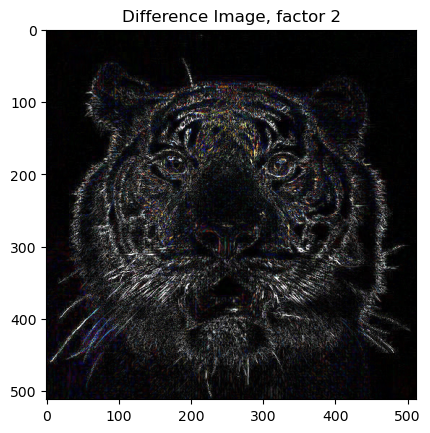

MSE: 0.006747908933826032
MSE: 0.006717109372184075
MSE: 0.006604747544889587
MSE: 0.006921869884404434


In [7]:
pictures = {
    # 'tiger':("LR_images/ci/downscaled_ci_flickr_wild_002021.jpg","HR_images/flickr_wild_002021.jpg"),
    'tiger':("testing_dataset/downscaled_ci_flickr_wild_002021.jpg","testing_dataset/flickr_wild_002021.jpg"),
    'dog':("LR_test/downscaled_ci_pixabay_dog_001489.jpg","HR_test/pixabay_dog_001489.jpg"),
    'wolf':("LR_test/downscaled_ci_pixabay_wild_000639.jpg","HR_test/pixabay_wild_000639.jpg"),
    'wave':("extraPics/downscaled_ci_waves.jpg","extraPics/waves.jpg"),
    'Ryan':("Ryan1.jpg","Ryan2.jpg")
}
lr_image,hr_image = pictures['tiger']
transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize to [-1, 1]
])

# Set the model to evaluation mode
model.eval()

image = plt.imread(lr_image)
image = Image.fromarray(image)
input_image = transform(image)

# Perform the inference
with torch.no_grad():
    input_image = input_image.to(device)  # Move the input image to the device
    input_image = input_image.unsqueeze(0)  # Add a batch dimension
    output = model(input_image)

# Convert to numpy array
numpy_image = output.squeeze(0).cpu().detach().numpy()

# Change the order of the dimensions from (C, H, W) to (H, W, C)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
output_im = np.array(numpy_image*255,dtype=int)

### Display the images###

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Display images in subplots
input_image = plt.imread(lr_image)
target_image = plt.imread(hr_image)
output_image = output_im

axes[0].imshow(input_image)
axes[0].set_title('LR Image')

axes[1].imshow(target_image)
axes[1].set_title('HR Image')

axes[2].imshow(output_im)
axes[2].set_title('Generated Image')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

difference_image = abs(output_im - target_image)
factor = 2
plt.imshow(difference_image*factor) # multiply by 2 to make the difference more visible
plt.title("Difference Image, factor "+ str(factor))
plt.show()

# find mse between original and reconstructed image
mse = np.mean((difference_image/255)**2)
print("MSE:", mse)
for i in range(3):
    channel_diff_img = difference_image[:,:,i]
    mse = np.mean((channel_diff_img/255)**2)
    print("MSE:", mse)

In [ ]:
#### Training loop for GAN
# SKIP if you are not using x8 architecture
for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        
        optimizer_G.zero_grad()
        
        # Generate outputs
        outputs = model(inputs)

        # Calculate the three loss components
        mse_loss = MSE_loss(outputs, targets)
        # vgg_loss = VGG_loss(outputs, targets) 
        adv_loss = adversarial_loss(discriminator(outputs), torch.ones_like(discriminator(outputs)))

        # Calculate the total loss as a weighted sum of the three components
        g_loss = weight_adv * adv_loss + weight_mse * mse_loss #+ weight_vgg * vgg_loss

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(targets), torch.ones_like(discriminator(targets)))
        fake_loss = adversarial_loss(discriminator(outputs.detach()), torch.zeros_like(discriminator(outputs.detach())))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Log Progress
        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Generator Loss: {:.4f}, Discriminator Loss: {:.4f}' 
                  .format(epoch, epochs, i, 15000, g_loss.item(), d_loss.item()))